# Decision Tree Classification: Study Hours vs. Exam Passing

### Introduction and  Theory

A **Decision Tree Classification** is a supervised learning algorithm that makes predictions by asking a series of questions about the data. It splits data into smaller, more specific nodes to distinguish between classes.

In this project, we will build the decision tree to predict if a student passes an exam based on **Average Score** and **Hours Studied**.

### The Mathematical Model
The tree decides where to split the data by measuring **Impurity**. We want to split a mixed group of students (some passed, some failed) into two groups.

#### Entropy ($H$)
We use **Entropy** to measure impurity. A group with only one class (e.g. all passed) has an Entropy of 0. A group perfectly split (50% passed, 50% failed) has an Entropy of 1.

$$H(S) = - \sum_{i} p_i \cdot \log_2(p_i)$$

* $S$ : The set of data.
* $p_i$ : The probability of class $i$ in that set.

#### 2. Information Gain ($IG$)
To find the best features and thresholds, the algorithm tries every possible split and calculates the **Information Gain**. This measures how much Entropy was reduced by the split. The goal of the algorithm is to reduce maximize Information Gain.

$$IG(S) = H(S) - \sum_{c} \frac{|S_c|}{|S|} H(S_c)$$

* $H(S)$ : Entropy of the parent group.
* $S_c$ : The child groups created by the split.
* $\frac{|S_c|}{|S|}$ : The weight of data that went into child group $c$.
* $H(S_c)$ : Entropy of child group $c$.

### Libraries Import

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.lines import lineStyles

### Data Preparation

In [82]:
# Creating the dataset
data = {
    "Student": ["Jeremy", "Noah", "Alyssa", "Daniel", "Sofia", "Colin", "Gracie", "Anne", "Jamal", "Trisha"],
    "Average Score": [65, 70, 82, 67, 92, 23, 96, 47, 75, 46],
    "Hours Studied": [3, 1, 3, 2, 4, 1, 5, 4, 2, 1],
    "Result": ["failed", "passed", "passed", "failed", "failed", "failed", "passed", "passed", "passed", "failed"]
}

# Converting to DataFrame
df = pd.DataFrame(data)

# Encoding "Passed" values
df["Result_Numeric"] = df["Result"].map({"passed": 1, "failed": 0})

print("Training Data:")
display(df)

Training Data:


,Student,Average Score,Hours Studied,Result,Result_Numeric
0,Jeremy,65,3,failed,0
1,Noah,70,1,passed,1
2,Alyssa,82,3,passed,1
3,Daniel,67,2,failed,0
4,Sofia,92,4,failed,0
5,Colin,23,1,failed,0
6,Gracie,96,5,passed,1
7,Anne,47,4,passed,1
8,Jamal,75,2,passed,1
9,Trisha,46,1,failed,0


### Calculating Entropy

In [83]:
# Extracting target labels
y = df["Result_Numeric"].values

# Determining exam pass rate
values, counts = np.unique(y, return_counts=True)

# Calculating probabilities
probabilities = counts / len(y)

# Calculating Entropy
parent_entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])

print(f"Counts (Fail, Pass): {counts}")
print(f"Probabilities: {probabilities}")
print(f"Parent Entropy H(S): {parent_entropy:.4f}")

Counts (Fail, Pass): [5 5]
Probabilities: [0.5 0.5]
Parent Entropy H(S): 1.0000


### Calculating the Best Splits

In [84]:
features = ["Average Score", "Hours Studied"]
min_samples_split = 2

# Finding root split
root_gain = -1
root_feature = None
root_threshold = None

# Iterating through features and thresholds
for feature in features:
    X_col = df[feature].values
    thresholds = (np.sort(np.unique(X_col))[:-1] + np.sort(np.unique(X_col))[1:]) / 2

    for threshold in thresholds:
        left_mask = X_col <= threshold
        right_mask = X_col > threshold

        if sum(left_mask) == 0 or sum(right_mask) == 0: continue

        # Calculating information gain
        y_left, y_right = y[left_mask], y[right_mask]

        # Calculating entropy
        _, c_l = np.unique(y_left, return_counts=True)
        e_l = -np.sum([(c/len(y_left)) * np.log2(c/len(y_left)) for c in c_l])

        _, c_r = np.unique(y_right, return_counts=True)
        e_r = -np.sum([(c/len(y_right)) * np.log2(c/len(y_right)) for c in c_r])

        weighted_e = (len(y_left)/len(y)) * e_l + (len(y_right)/len(y)) * e_r
        gain = parent_entropy - weighted_e

        if gain > root_gain:
            root_gain = gain
            root_feature = feature
            root_threshold = threshold

# Data preparation
root_col = df[root_feature].values
mask_left = root_col <= root_threshold
mask_right = root_col > root_threshold

df_left = df[mask_left]
y_left_node = y[mask_left]

df_right = df[mask_right]
y_right_node = y[mask_right]

# Finding left child split
left_gain = -1
left_feature = None
left_threshold = None

# Iterating through features and thresholds
_, c_p = np.unique(y_left_node, return_counts=True)
node_entropy = -np.sum([(c/len(y_left_node)) * np.log2(c/len(y_left_node)) for c in c_p])

if len(y_left_node) >= min_samples_split and node_entropy > 0:
    for feature in features:
        X_col = df_left[feature].values
        unique_vals = np.sort(np.unique(X_col))
        if len(unique_vals) < 2: continue
        thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2

        for threshold in thresholds:
            l_mask = X_col <= threshold
            r_mask = X_col > threshold
            if sum(l_mask) == 0 or sum(r_mask) == 0: continue

            y_l, y_r = y_left_node[l_mask], y_left_node[r_mask]

            _, c_l = np.unique(y_l, return_counts=True)
            e_l = -np.sum([(c/len(y_l)) * np.log2(c/len(y_l)) for c in c_l])

            _, c_r = np.unique(y_r, return_counts=True)
            e_r = -np.sum([(c/len(y_r)) * np.log2(c/len(y_r)) for c in c_r])

            w_e = (len(y_l)/len(y_left_node)) * e_l + (len(y_r)/len(y_left_node)) * e_r
            gain = node_entropy - w_e

            if gain > left_gain:
                left_gain = gain
                left_feature = feature
                left_threshold = threshold


# Finding right child split
right_gain = -1
right_feature = None
right_threshold = None

_, c_p = np.unique(y_right_node, return_counts=True)
node_entropy = -np.sum([(c/len(y_right_node)) * np.log2(c/len(y_right_node)) for c in c_p])

if len(y_right_node) >= min_samples_split and node_entropy > 0:
    for feature in features:
        X_col = df_right[feature].values
        unique_vals = np.sort(np.unique(X_col))
        if len(unique_vals) < 2: continue
        thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2

        for threshold in thresholds:
            l_mask = X_col <= threshold
            r_mask = X_col > threshold
            if sum(l_mask) == 0 or sum(r_mask) == 0: continue

            y_l, y_r = y_right_node[l_mask], y_right_node[r_mask]

            _, c_l = np.unique(y_l, return_counts=True)
            e_l = -np.sum([(c/len(y_l)) * np.log2(c/len(y_l)) for c in c_l])

            _, c_r = np.unique(y_r, return_counts=True)
            e_r = -np.sum([(c/len(y_r)) * np.log2(c/len(y_r)) for c in c_r])

            w_e = (len(y_l)/len(y_right_node)) * e_l + (len(y_r)/len(y_right_node)) * e_r
            gain = node_entropy - w_e

            if gain > right_gain:
                right_gain = gain
                right_feature = feature
                right_threshold = threshold

### Visualizing the Results

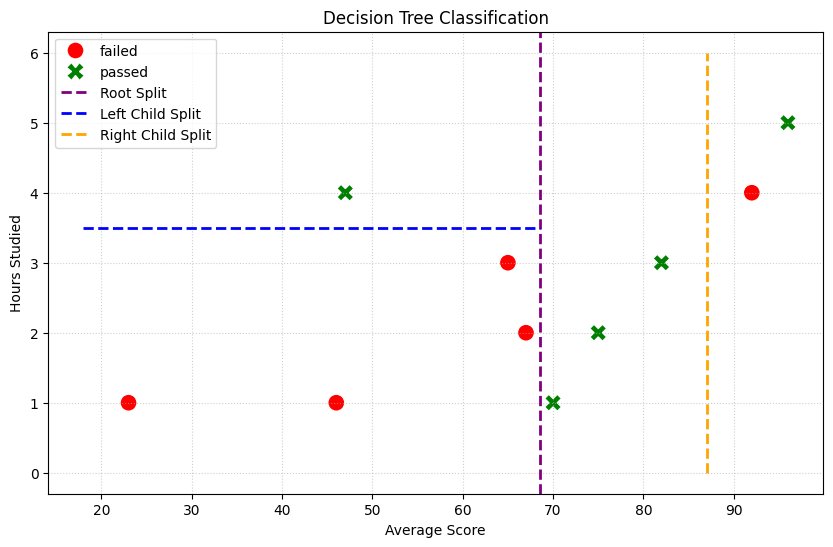

In [85]:
plt.figure(figsize=(10, 6))

# Plotting data points
sns.scatterplot(
    data=df, x="Average Score", y="Hours Studied", hue="Result",
    palette={"passed": "green", "failed": "red"}, s=150, style="Result"
)

# Determining Limits
x_min, x_max = df["Average Score"].min() - 5, df["Average Score"].max() + 5
y_min, y_max = df["Hours Studied"].min() - 1, df["Hours Studied"].max() + 1

# Plotting root split
if root_feature == "Average Score":
    plt.axvline(x=root_threshold, color="purple", lw=2, linestyle="--", label="Root Split")
    # Plotting left child split
    if left_feature == "Hours Studied":
        plt.hlines(y=left_threshold, xmin=x_min, xmax=root_threshold, colors="blue", linestyles="--", lw=2, label="Left Child Split")
    elif left_feature == "Average Score":
        plt.vlines(x=left_threshold, ymin=y_min, ymax=y_max, colors="blue", linestyles="--", lw=2, label="Left Child Split")

    # Plotting right child split
    if right_feature == "Hours Studied":
        plt.hlines(y=right_threshold, xmin=root_threshold, xmax=x_max, colors="orange", linestyles="--", lw=2, label="Right Child Split")
    elif right_feature == "Average Score":
        plt.vlines(x=right_threshold, ymin=y_min, ymax=y_max, colors="orange", linestyles="--", lw=2, label="Right Child Split")

elif root_feature == "Hours Studied":
    plt.axhline(y=root_threshold, color="purple", lw=2, linestyle="--", label="Root Split")

plt.legend(title=None)
plt.title("Decision Tree Classification")
plt.grid(True, linestyle=":", alpha=0.6)
plt.show()

### User Prediction

In [86]:
# User Input
input_score = 85.0
input_hours = 2.5

print(f"Average Score: {input_score}%")
print(f"Hours Studied: {input_hours}")

# Checking the root
if best_feature == "Average Score":
    val = input_score if root_feature == "Average Score" else input_hours

    if val <= root_threshold:
        # Checking left child
        if left_feature:
            val_l = input_score if left_feature == "Average Score" else input_hours
            if val_l <= left_threshold:
                result = "You will fail..."
            else:
                result = "You will pass!"
        else:
             result = "You will fail..."

    else:
        # Checking right child
        if right_feature:
            val_r = input_score if right_feature == "Average Score" else input_hours
            if val_r <= right_threshold:
                result = "You will pass!"
            else:
                result = "You will pass!"
        else:
            result = "You will pass!"

print(f"Prediction: {result}")

Average Score: 85.0%
Hours Studied: 2.5
Prediction: You will pass!
